In [2]:
# Kinda like a C struct
type StandardScalar
    mean::Array{Float64,2}
    std::Array{Float64,2}
end

include("nn.jl")

buildNetworkArchitecture (generic function with 1 method)


> *Coil field:* $$f(d) = \frac{k}{d^n}$$

> $n$ is the propagation constant

> *2D space:* $$f(x,y) = \frac{k}{(x^2+y^2)^{\frac{n}{2}}}$$

> *convert into dB:* $$RSS(d) = log(f(d))$$

> $$RSS(d) = log(k) - \frac{1}{n}log(d)$$

> $$RSS(d) = A - \frac{1}{n}log(d)$$ where $A = log(k)$

> **Trick:** use $e$ in order to avoid singularity of $f$ (a sort of saturation):

> $$f(x,y) = \frac{k}{x^2+y^2 + e}$$

> $$RSS(x,y) = A - {\frac{n}{2}}log(x^2+y^2 + e)$$

> In case of LF near field $n=3$
> $$RSS(x,y) = A - {\frac{3}{2}}log(x^2+y^2 + e)$$


In [ ]:
using PyPlot
using Interpolations

Xmin = -10
Xmax = 10
Xn = 50
Ymin = -10
Ymax = 10
Yn = 50

resample_factor = 4

# sampling
x = collect(linspace(Xmin, Xmax, Xn))
xn = length(x)
y = collect(linspace(Ymin, Ymax, Yn))
yn = length(y)

println(xn*yn)

xgrid = repmat(x, 1, yn)';
ygrid = repmat(y, 1, xn);

# resampling
xo = collect(linspace(Xmin, Xmax, Xn*resample_factor))
xno = length(xo)
yo = collect(linspace(Ymin, Ymax, Yn*resample_factor))
yno = length(yo)

xgrido = repmat(xo, 1, yno)';
ygrido = repmat(yo, 1, xno);

knots = (x, y)

type Antenna
    x::Float64
    y::Float64
end

# Antenna positioning
#          _
#          |
#      X1-X4--X2
#          |
#         X3
#

antennas = Antenna[]
push!(antennas, Antenna(-1, 0))
push!(antennas, Antenna(1, 0))
push!(antennas, Antenna(0, -2))
push!(antennas, Antenna(0, 0))

N_inputs = length(antennas)

# field
field(a, x, y) = 1./(((x.-antennas[a].x).^2 .+ (y.-antennas[a].y).^2 + 1).^(3/2))

# car shape
tg(x, y) = ((abs(x).<1) & (abs(y).<2))
field_dump(a, x, y) = e.^(3*(a<4)*tg(x,y) + 3*(a>=4)*(!tg(x,y)))

# field model: car + noise
flogv(a, x, y) = log(900*field(a, x, y)./field_dump(a, x, y) .+ 1*rand(size(x)))

itp = []
for i = 1:N_inputs
    push!(itp, interpolate(knots, flogv(i, xgrid, ygrid), Gridded(Linear())))
end

# _flogv(a, x, y) = itp[a][x, y]
function _flogv(a, x, y)
    z = zeros(length(x))
    for c = 1:length(x)
        z[c] = itp[a][y[c], x[c]]
        # @printf("%d, %d -> %d\n", x[c], y[c], z[c])
    end
    z = reshape(z, size(x))
end

fig = figure("An example", figsize=(12,14));
title("Field simulation")

for i=1:N_inputs
    ax = fig[:add_subplot](N_inputs,1,i, projection = "3d");
    title("field resample $i")
    z = _flogv(i, xgrido, ygrido)
    ax[:plot_surface](xgrido, ygrido, z, rstride=2, cstride=2, cmap=ColorMap("jet"), alpha=0.5, linewidth=0.2)
end

In [ ]:
function tg3(x, y)
    if ((abs(x)<1) && (abs(y)<2))
        return 1
    else
        if (abs(y)<2)
            if ((x>=1) && (x<2))
                return 2
            elseif ((x<=-1) && (x>-2))
                return 3
            else
                return 0
            end
        else
            if ((y<=-2) && (y>-3) && (abs(x)<2))
                return 4
            else
                return 0
            end
        end
        return 0
    end
end

function gen_datain(x, y)
    len = N_inputs
    rss = Array(Float64,(length(y),0)) 
    for i in 1:len
        rss = hcat(rss, _flogv(i, x, y))
    end
    return rss
end

function gen_dataout(x, y)
    len = length(x)
    out = [tg3(x[i], y[i]) for i in 1:len]
    return out
end

function gen_rand(n)
    out = 2*10*rand(2, n)-10
    return out
end

function gen_randn(n)
    out = 5*randn(2, n)
    return out
end


In [ ]:
N_train = 15000

println("generating training data")

# Rxy = 2*5*rand(2, N_train)-5
Rxy = gen_randn(N_train)

X_train = gen_datain(Rxy[1,:], Rxy[2,:])' - 0*(rand(N_inputs,length(Rxy[1,:]))-0.5)
y_train = gen_dataout(Rxy[1,:], Rxy[2,:])

# adapt
std_scalar = StandardScalar(mean(X_train,2), std(X_train,2))
X_train = (X_train .- std_scalar.mean) ./ std_scalar.std

y_train = sparse(convert(Array{Int64}, y_train + 1), 1:N_train, [1 for i in 1:N_train])

In [ ]:
using Gadfly

architecture = buildNetworkArchitecture(N_inputs, [75, 5], [reluComputingLayer, linearComputingLayer])
optimizer = AdaGradOptimizer(0.05, architecture)
crossEntropies = Float64[]
batchSize = 128
for i = 1:40000
   minibatch = collect((batchSize*i):(batchSize*i+batchSize)) % size(y_train,2) + 1 # take next 20 elements
   learningUnit = BackPropagationBatchLearningUnit(architecture, X_train[:,minibatch],
                                                  y_train[:,minibatch]);
   optimizer.updateRule!(learningUnit, optimizer.params)
   if i % 100 == 0  # this one costs so lets store entropies every 100 iterations
     push!(crossEntropies, crossEntropyError(architecture, X_train, y_train))
   end
end

Gadfly.plot(x = 1:length(crossEntropies), y = crossEntropies, Geom.line, Guide.xlabel("iterations"), Guide.ylabel("error"))

In [ ]:
N_test = 15000

mode = 0
if (mode == 1)
    Rxy = gen_randn(N_test)
else
    xn = yn = 100;
    N_test = xn*yn
    x = linspace(-4, 4, xn)
    y = linspace(-4, 4, yn)

    x = reshape(repmat(x', xn, 1), 1, length(repmat(x', xn, 1)))
    y = reshape(repmat(y, 1, yn), 1, length(repmat(y, 1, yn)))
    Rxy = [x;y]
end

X_test = gen_datain(Rxy[1,:], Rxy[2,:])' - 0.0*(ones(N_inputs,length(Rxy[1,:])))
y_test = gen_dataout(Rxy[1,:], Rxy[2,:])

# adapt
X_test = (X_test .- std_scalar.mean) ./ std_scalar.std

y_test = sparse(convert(Array{Int64}, y_test + 1),1:N_test, [1 for i in 1:N_test])

y_proba = infer(architecture, X_test)
mean(mapslices(x -> indmax(x), y_proba, 1)[:] .== mapslices(x -> indmax(x), full(y_test),1)[:])

In [ ]:
y_test_f = full(y_test)

r,c = size(y_test_f)
y_pred = Array(Int64,c)
y_test_full = Array(Int64,c)

for i in 1:c
    # must translate class index to label
    y_pred[i] = indmax(y_proba[:,i])
    y_test_full[i] = indmax(y_test_f[:,i])
end

println("Prediction accuracy: ", mean(y_pred .== y_test_full))

function confusion_matrix(y_true::Array{Int64,1},y_pred::Array{Int64,1})
    # Generate confusion matrix
    cm = zeros(Int64,5,5)

    for i in 1:c
        # translate label to index
        true_class = y_test_full[i]
        pred_class = y_pred[i]
        # pred class is the row, true class is the column
        cm[pred_class,true_class] += 1
    end
    return cm
end

confusion_matrix(y_test_full,y_pred)

In [ ]:
using PyPlot

fig = figure("An example", figsize=(10,5))

ax = gca() # get current axes
ax[:set_xlim]((-4,4))
ax[:set_ylim]((-4,4))
ax = fig[:add_subplot](1,2,1)
scatter(Rxy[1,:], Rxy[2,:], c=y_test_full, alpha=1, s=30, edgecolors="None", marker=".")
ax = fig[:add_subplot](1,2,2)
scatter(Rxy[1,:], Rxy[2,:], c=y_pred, alpha=1, s=30, edgecolors="None", marker=".")

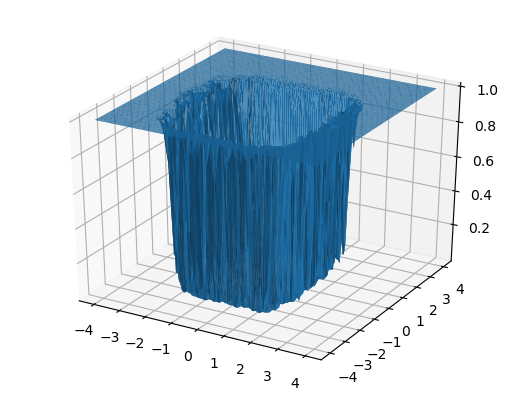

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa98276d250>

In [10]:
fig = figure()
plot_trisurf(Rxy[1,:], Rxy[2,:], y_proba[1,:])

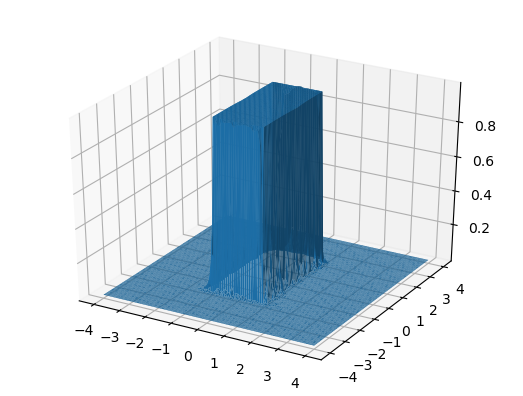

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa97da04f10>

In [11]:
plot_trisurf(Rxy[1,:], Rxy[2,:], y_proba[2,:])

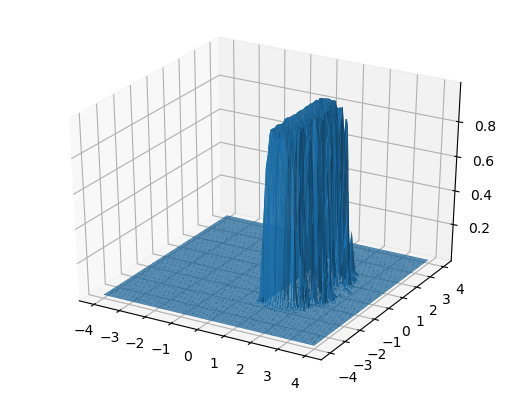

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa97c105c50>

In [12]:
plot_trisurf(Rxy[1,:], Rxy[2,:], y_proba[3,:])

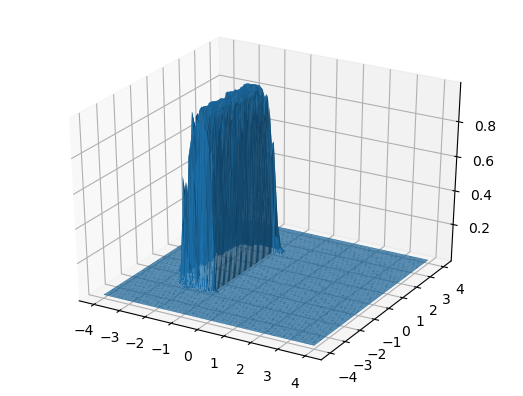

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa97f9f8a90>

In [13]:
plot_trisurf(Rxy[1,:], Rxy[2,:], y_proba[4,:])

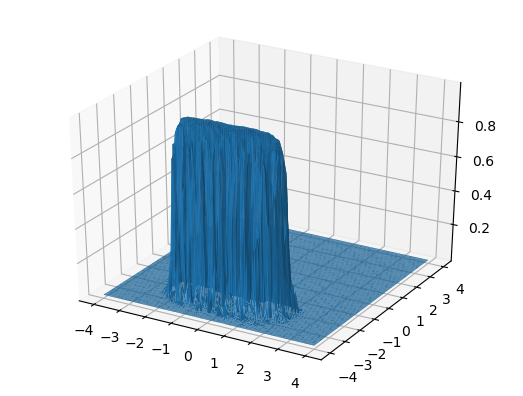

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x7fa97da333d0>

In [14]:
plot_trisurf(Rxy[1,:], Rxy[2,:], y_proba[5,:])

In [26]:
gen_randn(1)

2×1 Array{Float64,2}:
  0.596252
 -0.429718